# Ridge-I Challenge: 

### Design a network that combines supervised and unsupervised architectures in one model to achieve a classification task.

#### Architecture Requirement: 

The model must start with autoencoder(s) (stacking autoencoder is ok) that is connected through its hidden layer to another network of your choice.  The idea is given in the picture below
![ridge-net](https://drive.google.com/uc?id=1TiH8-iomMZb5u-irN-QL2bpoTOYZeqFt)

#### Data-set Constraint: 

Use the model to classify Cifar-10 dataset under the condition that the you can use 50% of the following classes for training (bird, deer and truck) while you can use any percentage you think is appropriate for the other classes.

#### Training:

You are free to propose the best number of epochs, mini batch size, optimizer and regularizing technique and data augmentation that you think is suitable for this scenario. You have the choice of training the autoencoder separately or in an end to end style with the classifier. Be creative.

In [0]:
### Solution starts from here

In [0]:
from google.colab import  drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Primary Imports

import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

print ("check version: ", tf.__version__)

check version:  2.2.0-rc3


#### Load the Cifar10 Data

In [0]:
(train_im, train_lab), (test_im, test_lab) = tf.keras.datasets.cifar10.load_data()

In [0]:
#### Normalize the images to pixel values (0, 1)
train_im, test_im = train_im/255.0 , test_im/255.0
#### Check the format of the data 
print ("train_im, train_lab types: ", type(train_im), type(train_lab))
#### check the shape of the data
print ("shape of images and labels array: ", train_im.shape, train_lab.shape) 

train_im, train_lab types:  <class 'numpy.ndarray'> <class 'numpy.ndarray'>
shape of images and labels array:  (50000, 32, 32, 3) (50000, 1)


In [0]:
#### Check the distribution of unique elements 
(unique, counts) = np.unique(train_lab, return_counts=True)

frequencies = np.asarray((unique, counts)).T

print (frequencies)
print (len(unique))

[[   0 5000]
 [   1 5000]
 [   2 5000]
 [   3 5000]
 [   4 5000]
 [   5 5000]
 [   6 5000]
 [   7 5000]
 [   8 5000]
 [   9 5000]]
10


#### Create Imbalanced Data-set 

Total number of training images are 50000. Each class have 5000 images. We will create an imbalanced data-set. 
* Task: Use only 50% of the following classes for training. Bird, Deer, Truck.   
* Approach: Shuffle the Data-set. 2500 images of bird, deer, truck would go in the training set along with 5000 images of remaining classes. The autoencoder network will learn from this imbalanced data-set (Approach1). 
* Approach 2: Use, the class imbalance info in the Autoencoder Network. (Final Approach). 

* The classifier network is added with the last layer of the Encoder. To train this Encoder + Classifier the class weight imbalance is taken into account.    

In [0]:
### Shuffle the data before rejecting random 2500 images of each of the selected classes 
np.random.seed(40)

im_indices = np.arange(train_im.shape[0])
np.random.shuffle(im_indices)
train_im = train_im[im_indices]
train_lab = train_lab[im_indices]

In [0]:
train_im_final = []
train_lab_final = []
excess_im = []
excess_lab = []

# # num_list = list(range(5001))
# # a = random.choice(num_list)
# # num_list.remove(a)

counter = [0, 0, 0]
# from the info of dataset 2, 4, 9 are the indices for bird, deer and truck labels. Check the class_types list before. 
 

for i, j in zip(train_im, train_lab):
  if j==2: # birds 
    if counter[0]< 2500: 
      excess_im.append(i)
      excess_lab.append(j)
      counter[0] +=1
    else:
      train_im_final.append(i)
      train_lab_final.append(j)    

  elif j==4: # deers
    if counter[1]<2500:
      excess_im.append(i)
      excess_lab.append(j)
      counter[1] +=1
    else:
      train_im_final.append(i)
      train_lab_final.append(j)

  elif j==9: # trucks
    if counter[2]<2500:  
      excess_im.append(i)
      excess_lab.append(j)
      counter[2] +=1
    else:
      train_im_final.append(i)
      train_lab_final.append(j)
  else: 
    train_im_final.append(i)
    train_lab_final.append(j)

In [0]:
train_im_final = np.array(train_im_final)
train_lab_final = np.array(train_lab_final)

print ("check the distribution now")

# print (np.argmax(new_train_lab, axis=1))

(unique1, counts1) = np.unique(train_lab_final, return_counts=True)

frequencies1 = np.asarray((unique1, counts1)).T

print (frequencies1)
print (len(unique1))

check the distribution now
[[   0 5000]
 [   1 5000]
 [   2 2500]
 [   3 5000]
 [   4 2500]
 [   5 5000]
 [   6 5000]
 [   7 5000]
 [   8 5000]
 [   9 2500]]
10


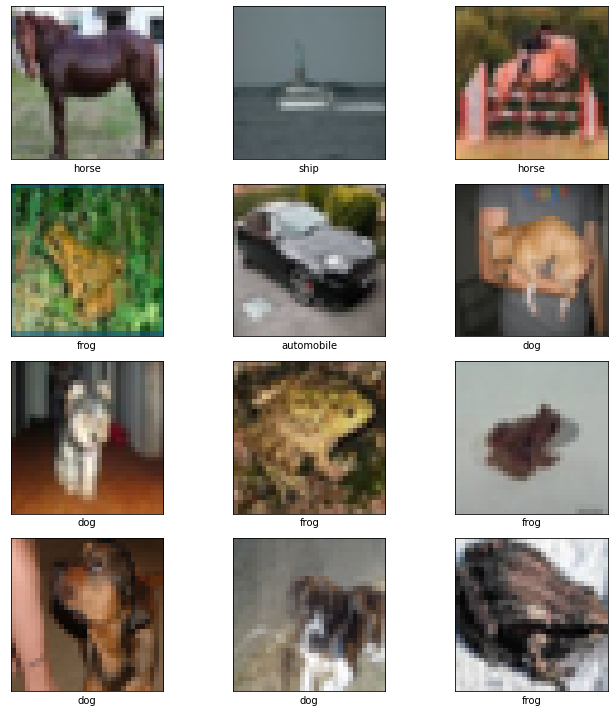

In [0]:
class_types = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck'] # from cifar-10 website

plt.figure(figsize=(10,10))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_im_final[i], cmap='gray')
    plt.xlabel(class_types[train_lab_final[i][0]])
plt.tight_layout()    
plt.show()

##### One hot encoding for the labels 

In [0]:
train_lab_categorical_final = tf.keras.utils.to_categorical(
    train_lab_final, num_classes=10, dtype='uint8')

test_labels_categorical = tf.keras.utils.to_categorical(
    test_lab, num_classes=10, dtype='uint8')

##### Train-Test Split

In [0]:
### Create a very small validation set from the trainin data 
# stratify 

from sklearn.model_selection import train_test_split 
train_im, valid_im, train_lab, valid_lab = train_test_split(train_im_final, train_lab_categorical_final, test_size=0.15, 
                                                            stratify=train_lab_categorical_final, 
                                                            random_state=40, shuffle = True)

print ("train data shape after the split: ", train_im.shape)
print ('new validation data shape: ', valid_im.shape)
print ("validation labels shape: ", valid_lab.shape)

train data shape after the split:  (36125, 32, 32, 3)
new validation data shape:  (6375, 32, 32, 3)
validation labels shape:  (6375, 10)


##### Get the relative class-weights

In [0]:
train_lab_cattoind = np.argmax(train_lab, axis=1)
### use class weights modeule from scikit learn 
### pass the array during Keras fit

from sklearn.utils import class_weight
mod_class_weights = class_weight.compute_class_weight('balanced', 
                                                      np.unique(train_lab_cattoind), 
                                                      train_lab_cattoind.reshape(train_lab_cattoind.shape[0]))
print (dict(enumerate(mod_class_weights)))
mod_class_weights = mod_class_weights.astype('float32')

{0: 0.85, 1: 0.85, 2: 1.7, 3: 0.85, 4: 1.7, 5: 0.85, 6: 0.85, 7: 0.85, 8: 0.85, 9: 1.7}


In [0]:
#### Necessary Imports for Neural Net 

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, \
     Flatten, concatenate, BatchNormalization, UpSampling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.activations import elu, relu
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

##### Data Augmentation 
Used for Classification ONLY

In [0]:
##### Include Little Data Augmentation 

train_DataGen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=0.2, rotation_range=45, 
                                                                width_shift_range=0.1, 
                                                                height_shift_range = 0.1, 
                                                                horizontal_flip=True)
 
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_set_aec = train_DataGen.flow(train_im, train_im, batch_size=128) # not used 
valid_set_aec = valid_datagen.flow(valid_im, valid_im, batch_size=128) # not used 

#### Different Iterator used for Comparison of AEC + Classifier with Simple Conv-net Model later on

train_set_simp_conv = train_DataGen.flow(train_im, train_lab, batch_size=128)
valid_set_simp_conv = valid_datagen.flow(valid_im, valid_lab, batch_size=128)

#### Define the Auto-Encoder (Encoder + Decoder). 

In [0]:
#### Start with the Auto-encoder 
### Build simple Encoder Block and Decoder block separately 


input_im = Input(shape = (32, 32, 3)) #shape of images

def encoder(input_im):
  conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',  kernel_regularizer=l2(0.001))(input_im) #32 x 32 x 32
  conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',  kernel_regularizer=l2(0.001))(conv1)
  conv1 = BatchNormalization()(conv1)
  pool1 = MaxPooling2D((2, 2))(conv1) #16 x 16 x 32
  conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',  kernel_regularizer=l2(0.001))(pool1) #16 x 16 x 64
  conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',  kernel_regularizer=l2(0.001))(conv2)
  conv2 = BatchNormalization()(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #8 x 8 x 64
  conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',  kernel_regularizer=l2(0.001))(pool2) 
  #8 x 8 x 128 # hopefully good enough depth
  conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',  kernel_regularizer=l2(0.001))(conv3)
  conv3 = BatchNormalization()(conv3)
  return conv3

In [0]:
def decoder(conv3):
  conv4    = Conv2D(64, (3, 3), activation='relu', padding='same',  kernel_regularizer=l2(0.001))(conv3) # 8 x 8 x 64
  conv4    = Conv2D(64, (3, 3), activation='relu', padding='same',  kernel_regularizer=l2(0.001))(conv4) 
  conv4    = BatchNormalization()(conv4)
  upsampl1 = UpSampling2D((2, 2))(conv4) # 16 x 16 x 64
  conv5    = Conv2D(32, (3, 3), activation='relu', padding='same',  kernel_regularizer=l2(0.001))(upsampl1) # 16 x 16 x 32
  conv5    = Conv2D(32, (3, 3), activation='relu', padding='same',  kernel_regularizer=l2(0.001))(conv5)
  conv5    = BatchNormalization()(conv5)
  upsampl2 = UpSampling2D((2, 2))(conv5) # 32 x 32 x 32 
  decode_l = Conv2D(3, (3, 3), activation='sigmoid', padding='same',  kernel_regularizer=l2(0.001))(upsampl2) # 32 x 32 x 3
  return decode_l

#### Define the Callbacks

In [0]:
#### Define Some CallBacks that would be used within every model fitting tasks 
#### Didn't use the EarlyStopping in AEC because of Low number of Epochs but used for the classifier  

def lrdecay(epoch):
  if epoch < 20:
    return 0.001
  else:
    return 0.001 * np.math.exp(0.1 * (20 - epoch))
lrdecay = tf.keras.callbacks.LearningRateScheduler(lrdecay) # learning rate decay  


def earlystop(mode):
  if mode=='acc':
    estop = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=10, mode='max')
  elif mode=='loss':
    estop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')
  return estop    

#### Set the Auto-enconder Model and Compile

In [0]:
simple_aec = Model(input_im, decoder(encoder(input_im)))

from keras import backend as K
from keras.objectives import mean_squared_error


def generate_sample_weights(train_data, class_weight_dictionary): 
    sample_weights = [class_weight_dictionary[np.where(one_hot_enc==1)[0][0]] for one_hot_enc in train_data]
    return np.asarray(sample_weights)



def L2err(y_true, y_pred): 
  mse = mean_squared_error(y_true, y_pred)  # distance as error for pixel misclassification 
  return K.sum(mse, axis=(1, 2))      



simple_aec.compile(optimizer = Adam(lr=1e-3), 
                   loss =L2err, metrics=['acc'])

Using TensorFlow backend.


In [0]:
# samp_weights = generate_sample_weights(train_lab, mod_class_weights)
# print (type(samp_weights), len(samp_weights), samp_weights.shape, samp_weights[5])

<class 'numpy.ndarray'> 36125 (36125,) 1.7


In [0]:
simple_aec.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928 

In [0]:
### Train the Autoencoder 

### choose some batch size and epoch, maybe tune later 

batch_size = 128 # tested 32, 64, 128, 256 
epochs = 30 # tested 20, 40

simple_aec_train = simple_aec.fit(train_im, train_im, batch_size=batch_size, 
                                  epochs=epochs, 
                                  validation_data = (valid_im, valid_im),
                                  callbacks=[lrdecay], 
                                  sample_weight = generate_sample_weights(train_lab, dict(enumerate(mod_class_weights))))

Epoch 1/30
283/283 [==============================] - 9s 31ms/step - loss: 11.0632 - acc: 0.6660 - val_loss: 19.9549 - val_acc: 0.6293 - lr: 0.0010
Epoch 2/30
283/283 [==============================] - 8s 29ms/step - loss: 5.7017 - acc: 0.7524 - val_loss: 5.6728 - val_acc: 0.7386 - lr: 0.0010
Epoch 3/30
283/283 [==============================] - 8s 29ms/step - loss: 4.6951 - acc: 0.7738 - val_loss: 6.3863 - val_acc: 0.7930 - lr: 0.0010
Epoch 4/30
283/283 [==============================] - 8s 28ms/step - loss: 4.2172 - acc: 0.7839 - val_loss: 4.5394 - val_acc: 0.7860 - lr: 0.0010
Epoch 5/30
283/283 [==============================] - 8s 29ms/step - loss: 3.7789 - acc: 0.7911 - val_loss: 3.5142 - val_acc: 0.7654 - lr: 0.0010
Epoch 6/30
283/283 [==============================] - 8s 28ms/step - loss: 3.4312 - acc: 0.7961 - val_loss: 3.9135 - val_acc: 0.7847 - lr: 0.0010
Epoch 7/30
283/283 [==============================] - 8s 28ms/step - loss: 3.1136 - acc: 0.8013 - val_loss: 2.9324 - val_a

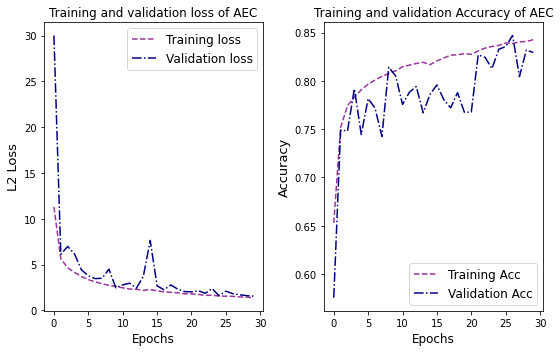

In [0]:
loss = simple_aec_train.history['loss'] 
val_loss = simple_aec_train.history['val_loss'] 

acc = simple_aec_train.history['acc']
val_acc = simple_aec_train.history['val_acc']

epochs = range(30)
plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, linestyle='--', label='Training loss', color='purple', alpha=0.8)
plt.plot(epochs, val_loss, linestyle='-.', label='Validation loss', color='navy')
plt.title('Training and validation loss of AEC', fontsize=12)
plt.legend(fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('L2 Loss', fontsize=13)

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, linestyle='--', label='Training Acc', color='purple', alpha=0.8)
plt.plot(epochs, val_acc, linestyle='-.', label='Validation Acc', color='navy')
plt.title('Training and validation Accuracy of AEC', fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=13)

plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/challenge/AEC_train.jpg', dpi=250)

plt.show()

In [0]:
### save the weights if necessary for future use 
simple_aec.save_weights('/content/gdrive/My Drive/Colab Notebooks/challenge/simple_aec.h5')

#### Define a Simple Classifier Network 
(Compare between a Dense and Conv. Net)

In [0]:
### Extract the Bottleneck Features to Use it for classification 
### here I will use Fully connected layers as one model, and Covolution layers + Dense Layers as another 
### Let's Define these models separately 
### total number of classes = 10 


def fc(encoder_part):
  flat = Flatten()(encoder_part)
  den1 = Dense(256, activation='relu')(flat)
  den1 = Dropout(0.40)(den1)
  den2 = Dense(64, activation='relu')(den1)
  den2 = Dropout(0.30)(den2)
  output = Dense(len(class_types), activation='softmax')(den2) # softmax activation for multi-class classification 
  return output 


def conv(encoder_part): 
   ''' encoder part ended with dimension 8 x 8 x 128.
   Won't perform any pooling because the feature space dimension is 
   already too small. For the dense layers, 
   same values as fc model are used, just for relevant comparison. '''
   conv1 = Conv2D(128, (3,3), padding="same", activation='relu',  kernel_regularizer=l2(0.001))(encoder_part)
   conv1 = BatchNormalization()(conv1)
   conv2 = Conv2D(256, (3,3), padding="same", activation='relu',  kernel_regularizer=l2(0.001))(conv1)
   conv2 = BatchNormalization()(conv2)
   flt = Flatten()(conv2)
   dense1 = Dense(256, activation='relu')(flt)
   dense1 = Dropout(0.40)(dense1)
   dense2 = Dense(64, activation='relu')(dense1)
   dense2 = Dropout(0.30)(dense2)
   output = Dense(len(class_types), activation='softmax')(dense2)
   return output

In [0]:
### define the conditional function to choose how we want to extract the features at bottleneck

encode_im = encoder(input_im)

def choose_classifier(cls_model, input_im):
  if cls_model == 'fc':
    newModel = Model(input_im, fc(encode_im))
  elif cls_model == 'conv':
    newModel = Model(input_im, conv(encode_im))
  return newModel    

# full_model = Model(input_im, fc(encode_im))

#### Stack the Encoder part of Auto-Encoder with Classifier

In [0]:
### Get the Weights from the AEC and Set these weights fixed for AEC + Classifier  

for fc_cls, aec in zip(choose_classifier('fc', input_im).layers[:12], simple_aec.layers[0:12]):
   fc_cls.set_weights(aec.get_weights())

for conv_cls, aec in zip(choose_classifier('conv', input_im).layers[:12], simple_aec.layers[0:12]):
   conv_cls.set_weights(aec.get_weights())

# simple_aec.get_weights()[0][1]

In [0]:
# Check whether the weight are same or not !

print ("check weights same fc+encoder, full autoencoder:", 
       np.array_equal(choose_classifier('fc', input_im).get_weights()[0][1], simple_aec.get_weights()[0][1]))

print ("check weights same conv+encoder, full autoencoder: ", 
       np.array_equal(choose_classifier('conv', input_im).get_weights()[0][1], simple_aec.get_weights()[0][1]))

check weights same fc+encoder, full autoencoder: True
check weights same conv+encoder, full autoencoder:  True


#### Only Fine-Tune the Added Classifier Network 
Don't train the enocder network anymore.  

In [0]:
#### won't train the encoder part of the network 

for lfc in choose_classifier('fc', input_im).layers[0:12]:
  lfc.trainable = False

for lconv in choose_classifier('conv', input_im).layers[0:12]:
  lconv.trainable = False  

##### Compile the Encoder + Dense Model 

In [0]:
aec_fc = choose_classifier('fc', input_im)
aec_fc.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['acc'])

##### Compile the Enoder + Conv Model

In [0]:
aec_conv = choose_classifier('conv', input_im)
aec_conv.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['acc'])

In [0]:
aec_fc_train = aec_fc.fit(train_set_simp_conv,
                          epochs=60, 
                          steps_per_epoch=train_im.shape[0]/batch_size,
                          validation_steps = valid_im.shape[0]/batch_size, 
                          validation_data=(valid_set_simp_conv),  
                          class_weight=dict(enumerate(mod_class_weights)),  
                          callbacks=[lrdecay, earlystop('acc')])

Epoch 1/60
283/282 [==============================] - 16s 58ms/step - loss: 2.2444 - acc: 0.2491 - val_loss: 1.8718 - val_acc: 0.3740 - lr: 0.0010
Epoch 2/60
283/282 [==============================] - 16s 58ms/step - loss: 2.0219 - acc: 0.3221 - val_loss: 1.7788 - val_acc: 0.4309 - lr: 0.0010
Epoch 3/60
283/282 [==============================] - 16s 57ms/step - loss: 1.9511 - acc: 0.3491 - val_loss: 1.7272 - val_acc: 0.4389 - lr: 0.0010
Epoch 4/60
283/282 [==============================] - 16s 58ms/step - loss: 1.9074 - acc: 0.3602 - val_loss: 1.7246 - val_acc: 0.4318 - lr: 0.0010
Epoch 5/60
283/282 [==============================] - 16s 58ms/step - loss: 1.8697 - acc: 0.3782 - val_loss: 1.6923 - val_acc: 0.4447 - lr: 0.0010
Epoch 6/60
283/282 [==============================] - 16s 57ms/step - loss: 1.8500 - acc: 0.3874 - val_loss: 1.6631 - val_acc: 0.4511 - lr: 0.0010
Epoch 7/60
283/282 [==============================] - 16s 57ms/step - loss: 1.8424 - acc: 0.3952 - val_loss: 1.6374 - 

In [0]:
aec_conv_train = aec_conv.fit(train_set_simp_conv, 
                          epochs=60, 
                          steps_per_epoch=train_im.shape[0]/batch_size,
                          validation_data=(valid_set_simp_conv), 
                          validation_steps = valid_im.shape[0]/batch_size,
                          class_weight=dict(enumerate(mod_class_weights)), 
                          callbacks=[lrdecay] )

Epoch 1/60
283/282 [==============================] - 18s 62ms/step - loss: 2.5540 - acc: 0.2321 - val_loss: 2.1153 - val_acc: 0.4083 - lr: 0.0010
Epoch 2/60
283/282 [==============================] - 17s 61ms/step - loss: 2.1853 - acc: 0.3387 - val_loss: 1.8109 - val_acc: 0.4789 - lr: 0.0010
Epoch 3/60
283/282 [==============================] - 17s 61ms/step - loss: 1.9890 - acc: 0.4162 - val_loss: 1.6805 - val_acc: 0.5347 - lr: 0.0010
Epoch 4/60
283/282 [==============================] - 17s 62ms/step - loss: 1.8859 - acc: 0.4528 - val_loss: 1.7433 - val_acc: 0.4974 - lr: 0.0010
Epoch 5/60
283/282 [==============================] - 17s 61ms/step - loss: 1.8259 - acc: 0.4829 - val_loss: 1.5879 - val_acc: 0.5780 - lr: 0.0010
Epoch 6/60
283/282 [==============================] - 17s 61ms/step - loss: 1.7821 - acc: 0.5033 - val_loss: 1.6054 - val_acc: 0.5589 - lr: 0.0010
Epoch 7/60
283/282 [==============================] - 17s 62ms/step - loss: 1.7403 - acc: 0.5238 - val_loss: 1.5801 - 

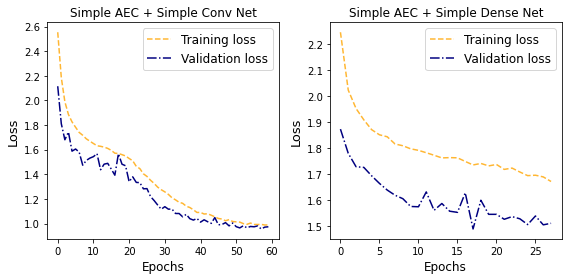

In [0]:
#### Comapre the Classifiers
#### 1a. Plot the results of training - Loss

loss_aec_conv = aec_conv_train.history['loss'] 
val_loss_aec_conv = aec_conv_train.history['val_loss'] 

loss_aec_fc = aec_fc_train.history['loss']
val_loss_aec_fc = aec_fc_train.history['val_loss']


plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(range(len(loss_aec_conv)), loss_aec_conv, linestyle='--', label='Training loss', color='orange', alpha=0.8)
plt.plot(range(len(val_loss_aec_conv)), val_loss_aec_conv, linestyle='-.', label='Validation loss', color='navy')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=13)
plt.title('Simple AEC + Simple Conv Net', fontsize=12)
plt.legend(fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(range(len(loss_aec_fc)), loss_aec_fc, linestyle='--', label='Training loss', color='orange', alpha=0.8)
plt.plot(range(len(val_loss_aec_fc)), val_loss_aec_fc, linestyle='-.', label='Validation loss', color='navy')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=13)
plt.title('Simple AEC + Simple Dense Net', fontsize=12)
plt.legend(fontsize=12)

plt.tight_layout()
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/challenge/AEC_Class_train.jpg', dpi=250)
plt.show()

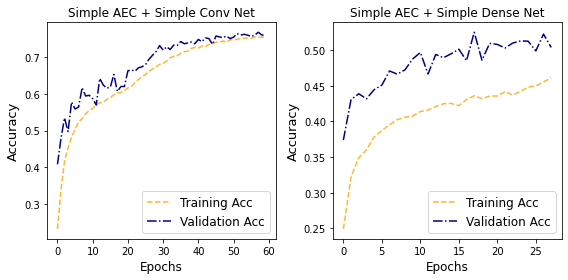

In [0]:
#### 1b. Plot the results of training - Accuracy

acc_aec_conv = aec_conv_train.history['acc'] 
val_acc_aec_conv = aec_conv_train.history['val_acc'] 

acc_aec_fc = aec_fc_train.history['acc']
val_acc_aec_fc = aec_fc_train.history['val_acc']


plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(range(len(acc_aec_conv)), acc_aec_conv, linestyle='--', label='Training Acc', color='orange', alpha=0.8)
plt.plot(range(len(acc_aec_conv)), val_acc_aec_conv, linestyle='-.', label='Validation Acc', color='navy')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=13)
plt.title('Simple AEC + Simple Conv Net', fontsize=12)
plt.legend(fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(range(len(acc_aec_fc)), acc_aec_fc, linestyle='--', label='Training Acc', color='orange', alpha=0.8)
plt.plot(range(len(acc_aec_fc)), val_acc_aec_fc, linestyle='-.', label='Validation Acc', color='navy')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=13)
plt.title('Simple AEC + Simple Dense Net', fontsize=12)
plt.legend(fontsize=12)

plt.tight_layout()
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/challenge/AEC_Class_train_acc.jpg', dpi=250)

plt.show()

In [0]:
## Check the performance on the test data 
test_aecconv_result = aec_conv.evaluate(test_im, test_labels_categorical, verbose=0)

print ("test autoencoder + conv model loss: ", test_aecconv_result[0])
print ("test autoencoder + conv model accuracy: ", test_aecconv_result[1])

test autoencoder + conv model loss:  0.9945580363273621
test autoencoder + conv model accuracy:  0.758400022983551


In [0]:
## Check the performance on the test data 
test_aecfc_result = aec_fc.evaluate(test_im, test_labels_categorical, verbose=0)

print ("test autoencoder + conv model loss: ", test_aecfc_result[0])
print ("test autoencoder + conv model accuracy: ", test_aecfc_result[1])

test autoencoder + conv model loss:  1.5011005401611328
test autoencoder + conv model accuracy:  0.5074999928474426


In [0]:
from sklearn.metrics import confusion_matrix, classification_report

def conf_matrix(predictions, model_name): 
    ''' Plots conf. matrix and classification report '''
    cm=confusion_matrix(test_lab, np.argmax(np.round(predictions), axis=1))
    print("Classification Report:\n")
    cr=classification_report(test_lab,
                                np.argmax(np.round(predictions), axis=1), 
                                target_names=[class_types[i] for i in range(len(class_types))])
    print(cr)
    plt.figure(figsize=(12,12))
    sns_hmp = sns.heatmap(cm, annot=True, xticklabels = [class_types[i] for i in range(len(class_types))], 
                yticklabels = [class_types[i] for i in range(len(class_types))], fmt="d")
    fig = sns_hmp.get_figure()
    fig.savefig('/content/gdrive/My Drive/Colab Notebooks/challenge/heatmap_aec%s.jpg'%(model_name), dpi=250)

Classification Report:

              precision    recall  f1-score   support

    airplane       0.32      0.88      0.47      1000
  automobile       0.88      0.86      0.87      1000
        bird       0.88      0.48      0.62      1000
         cat       0.83      0.33      0.47      1000
        deer       0.88      0.52      0.65      1000
         dog       0.82      0.55      0.66      1000
        frog       0.74      0.86      0.80      1000
       horse       0.84      0.77      0.81      1000
        ship       0.91      0.82      0.87      1000
       truck       0.78      0.85      0.81      1000

    accuracy                           0.69     10000
   macro avg       0.79      0.69      0.70     10000
weighted avg       0.79      0.69      0.70     10000



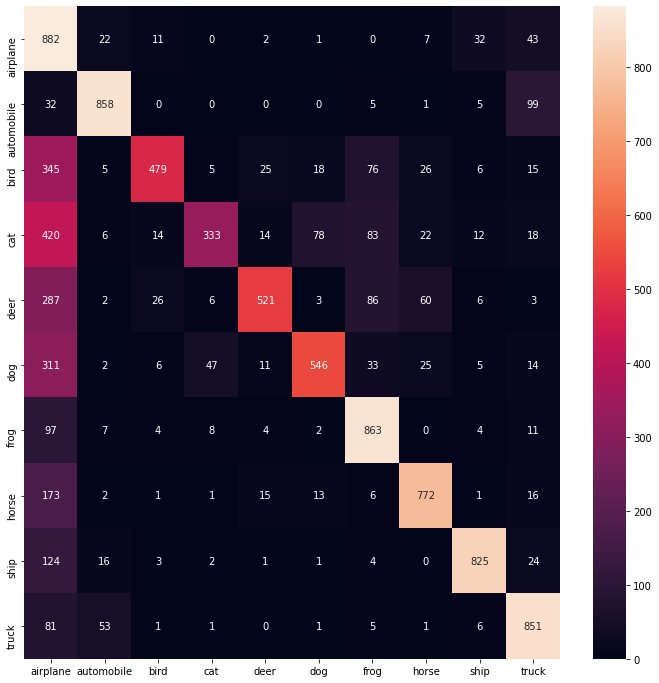

In [0]:
### Get the Prediction  and plot conf matrix 
pred_class_aecconv = aec_conv.predict(test_im)

conf_matrix(pred_class_aecconv, 'conv')

In [0]:
### Get the Prediction  and plot conf matrix for AEC + Dense 
# pred_class_aecfc = aec_fc.predict(test_im)

# conf_matrix(pred_class_aecfc, 'dense')

#### Check the Reuslts with Simple Conv. Net only

It is checked here whether using only the convloutional block (that was previously used along with encoder network for classification) can produce better/worse classification. 

Our hypothesis is that using the latent variables as input for the conv. net would produce better results.  

* Model: Use the same convolution + dense block which was used for classification. This block didn't have any maxpooling layers as the encoded features were as used as input. To make the comparison fair 1 maxpooling layer was added in this new simple conv. net model. Otherwise no point of training!  The dense (only) network is not checked as the performance of AEC + Dense net was poor (previous results).    

In [0]:
##### Compare everything with a Simple Convolution Just for a check 

#### For a fair comparison the encoder block is added with the dense block 


input_im = Input(shape = (32, 32, 3)) #shape of images

def simple_conv(input_im):
  conv1 = Conv2D(128, (3,3), padding="same", activation='relu',  kernel_regularizer=l2(0.001))(input_im)
  conv1 = BatchNormalization()(conv1)
  pool1 = MaxPooling2D((2, 2))(conv1) #16 x 16 x 32
  conv2 = Conv2D(256, (3,3), padding="same", activation='relu',  kernel_regularizer=l2(0.001))(pool1)
  conv2 = BatchNormalization()(conv2)
  flt = Flatten()(conv2)
  dense1 = Dense(256, activation='relu')(flt)
  dense1 = Dropout(0.40)(dense1)
  dense2 = Dense(64, activation='relu')(dense1)
  dense2 = Dropout(0.30)(dense2)
  output = Dense(len(class_types), activation='softmax')(dense2) 
  return output

simple_conv_model = Model(input_im, simple_conv(input_im))
simple_conv_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 128)       3584      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 256)       1024      
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0     

In [0]:
simple_conv_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001),  metrics=['acc'])

In [0]:
batch_size=128 
epochs=60

simple_conv_train = simple_conv_model.fit(train_set_simp_conv, 
                                          epochs=epochs, 
                                          validation_data = (valid_set_simp_conv), 
                                          steps_per_epoch=train_im.shape[0]/batch_size, 
                                          validation_steps = valid_im.shape[0]/batch_size, 
                                          class_weights=dict(enumerate(mod_class_weights)), 
                                          callbacks=[lrdecay, earlystop('acc')])

Epoch 1/60
283/282 [==============================] - 20s 70ms/step - loss: 2.7834 - acc: 0.1856 - val_loss: 7.7411 - val_acc: 0.1267 - lr: 0.0010
Epoch 2/60
283/282 [==============================] - 19s 68ms/step - loss: 2.1787 - acc: 0.2423 - val_loss: 2.1233 - val_acc: 0.2326 - lr: 0.0010
Epoch 3/60
283/282 [==============================] - 19s 67ms/step - loss: 2.0671 - acc: 0.2637 - val_loss: 1.9366 - val_acc: 0.3137 - lr: 0.0010
Epoch 4/60
283/282 [==============================] - 19s 68ms/step - loss: 2.0107 - acc: 0.2708 - val_loss: 1.8652 - val_acc: 0.3821 - lr: 0.0010
Epoch 5/60
283/282 [==============================] - 19s 67ms/step - loss: 1.9766 - acc: 0.2810 - val_loss: 1.7762 - val_acc: 0.4000 - lr: 0.0010
Epoch 6/60
283/282 [==============================] - 19s 66ms/step - loss: 1.9539 - acc: 0.2821 - val_loss: 1.7869 - val_acc: 0.4052 - lr: 0.0010
Epoch 7/60
283/282 [==============================] - 18s 65ms/step - loss: 1.9404 - acc: 0.2849 - val_loss: 1.8941 - 

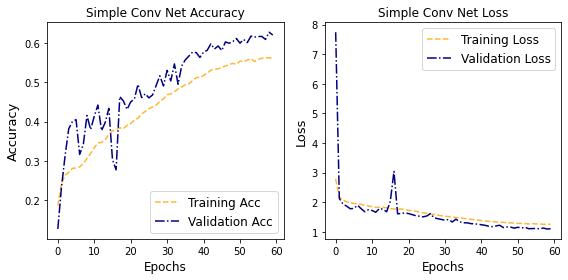

In [0]:
acc_simp_conv = simple_conv_train.history['acc'] 
val_acc_simp_conv = simple_conv_train.history['val_acc'] 

loss_simp_conv = simple_conv_train.history['loss']
val_loss_simp_conv = simple_conv_train.history['val_loss']


plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(range(len(acc_simp_conv)), acc_simp_conv, linestyle='--', label='Training Acc', color='orange', alpha=0.8)
plt.plot(range(len(val_acc_simp_conv)), val_acc_simp_conv, linestyle='-.', label='Validation Acc', color='navy')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=13)
plt.title('Simple Conv Net Accuracy', fontsize=12)
plt.legend(fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(range(len(loss_simp_conv)), loss_simp_conv, linestyle='--', label='Training Loss', color='orange', alpha=0.8)
plt.plot(range(len(val_loss_simp_conv)), val_loss_simp_conv, linestyle='-.', label='Validation Loss', color='navy')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=13)
plt.title('Simple Conv Net Loss', fontsize=12)
plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig('/content/gdrive/My Drive/Colab Notebooks/challenge/Simple_conv_train.jpg', dpi=250)
plt.show()

In [0]:
## Check the performance on the test data 
test_simpconv_result = simple_conv_model.evaluate(test_im, test_labels_categorical, verbose=0)

print ("test simple conv model loss: ", test_simpconv_result[0])
print ("test simple conv model accuracy: ", test_simpconv_result[1])

test simple conv model loss:  1.1985883712768555
test simple conv model accuracy:  0.5460000038146973


Classification Report:

              precision    recall  f1-score   support

    airplane       0.16      0.94      0.28      1000
  automobile       0.57      0.88      0.69      1000
        bird       1.00      0.01      0.02      1000
         cat       0.77      0.02      0.04      1000
        deer       0.67      0.00      0.00      1000
         dog       0.78      0.16      0.26      1000
        frog       0.79      0.65      0.71      1000
       horse       0.71      0.71      0.71      1000
        ship       0.95      0.61      0.75      1000
       truck       1.00      0.00      0.00      1000

    accuracy                           0.40     10000
   macro avg       0.74      0.40      0.35     10000
weighted avg       0.74      0.40      0.35     10000



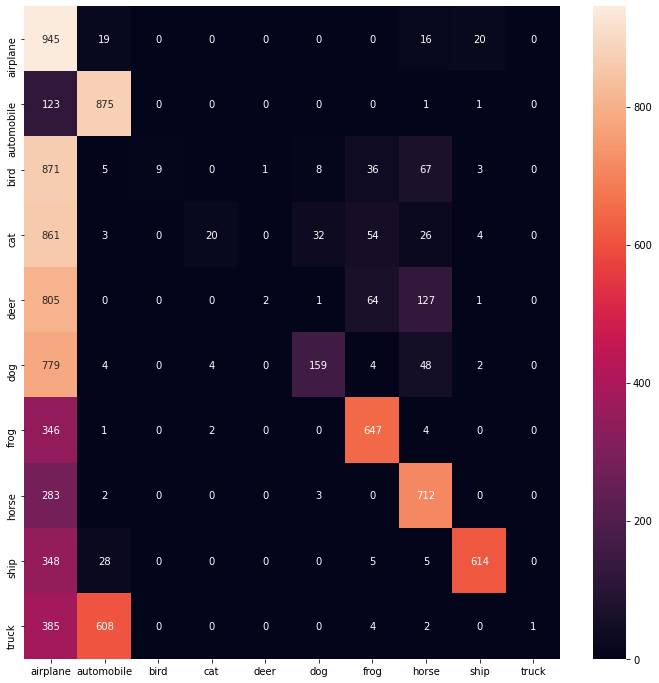

In [0]:
### Get the Prediction and Plot CM

pred_class_simpconv = simple_conv_model.predict(test_im)
conf_matrix(pred_class_simpconv, 'simpconv')

Encoded features when fed through the simple conv net indeed performs better classification, than directly feeding images to the conv net!  